In [12]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt

In [13]:
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2.7.0+cu126
Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti


In [14]:
class FishDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform  # Initialize this attribute
        self.classes = sorted([d for d in os.listdir(img_dir) 
                                    if os.path.isdir(os.path.join(img_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # data elements will be (img path, class index)
        self.data = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append((img_path, class_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, class_idx = self.data[index]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
    
        return image, class_idx

In [15]:
def get_transforms():
    """Define transforms for training and validation"""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [16]:
def create_prompt_function(template="a photograph of a raw fillet of {}"):
    def format_prompt(class_name):
        return template.format(class_name)
    return format_prompt

# CLIP-Optimized DataLoader Creator
def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=4):

    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    
    dataloader_kwargs = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers if cuda_available else 0,
        'pin_memory': cuda_available, 
        'persistent_workers': num_workers > 0,
        'prefetch_factor': 2 if num_workers > 0 else 2,
    }
    
    train_loader = DataLoader(train_dataset, **dataloader_kwargs)
    
 
    val_kwargs = dataloader_kwargs.copy()
    val_kwargs['shuffle'] = False
    val_loader = DataLoader(val_dataset, **val_kwargs)
    
    print(f"Device: {device}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Classes: {train_dataset.classes}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader, device

In [17]:
train_dir = './all/train'
val_dir = './all/val'
train_transform, val_transform = get_transforms()
prompt_fn = create_prompt_function("a photograph of a raw fillet of {}")
train_dataset = FishDataset(train_dir, transform=train_transform, target_transform=prompt_fn)
val_dataset = FishDataset(val_dir, transform=val_transform, target_transform=prompt_fn)

In [18]:
train_loader, val_loader, device = create_dataloaders(
    train_dataset, val_dataset, batch_size=32, num_workers=4
)

Device: cuda
Number of classes: 5
Classes: ['catfish', 'cod', 'salmon', 'sea bass', 'tuna']
Training samples: 1324
Validation samples: 708


In [19]:
import clip
from transformers import CLIPProcessor, CLIPModel

In [20]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model=model.to(device)

In [ ]:
def test_loop(dataloader: DataLoader, model, loss_fn, device):
    model.eval()
    # size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    classes = dataloader.dataset.classes
    prompts = [f"a photograph of a raw fillet of {class_name}" for class_name in classes]
    # prompts = [f"{class_name}" for class_name in classes]
    num_samples = len(dataloader.dataset)
    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            pil_images = []
            for img_tensor in X:
                img_pil = transforms.ToPILImage()(img_tensor)
                pil_images.append(img_pil)
            
            inputs = processor(text=prompts, images=pil_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            
            logits_per_image = outputs.logits_per_image  # shape: (batch_size, num_classes)
            probs = logits_per_image.softmax(dim=1)  # This is your likelihood vector!
            pred = probs.argmax(dim=1)
            indices_inspect = [5,7,12,14]
            if idx in indices_inspect:
                print(f"\n{'='*50}")
                print(f"BATCH {idx} RESULTS")
                print(f"{'='*50}")
                
                num_to_show = min(3, X.shape[0])
                fig, axes = plt.subplots(1, num_to_show, figsize=(15, 5))
                if num_to_show == 1:
                    axes = [axes]
                
                for i in range(num_to_show):
                    axes[i].imshow(pil_images[i])
                    axes[i].axis('off')
                    
                    true_class = classes[y[i].item()]
                    pred_class = classes[pred[i].item()]
                    confidence = probs[i].max().item()
                    
                    title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}"
                    axes[i].set_title(title, fontsize=10)
                
                plt.tight_layout()
                plt.show()
                
                print(f"\nDetailed Predictions:")
                for i in range(num_to_show):
                    print(f"\nSample {i}:")
                    print(f"  True class: {classes[y[i].item()]}")
                    print(f"  Predicted class: {classes[pred[i].item()]}")
                    print(f"  Likelihood vector:")
                    for j, (class_name, prob) in enumerate(zip(classes, probs[i].cpu().numpy())):
                        marker = " ← PREDICTED" if j == pred[i].item() else ""
                        print(f"    {class_name:>10}: {prob:.4f}{marker}")
                
                print(f"\nBatch predicted classes: {pred}")
                print(f"Batch true classes: {y}")
                print(f"{'='*50}\n")
            
    correct += (pred == y).sum().item()
    test_loss += loss_fn(logits_per_image, y).item()
    accuracy = 100.0 * correct / num_samples
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


BATCH 5 RESULTS


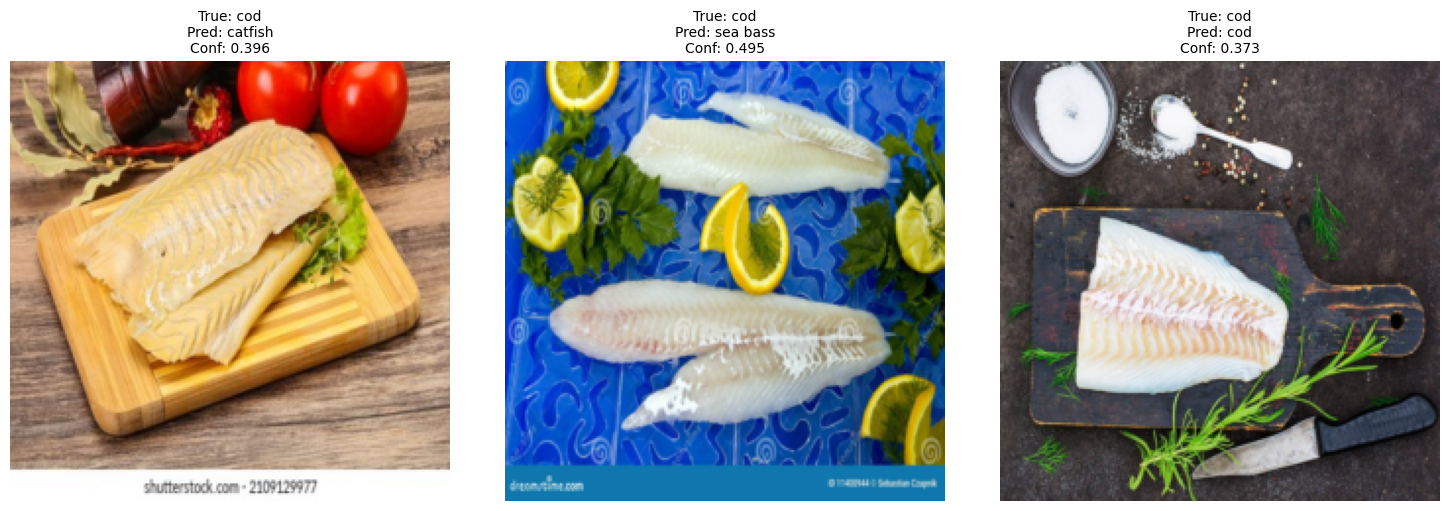


Detailed Predictions:

Sample 0:
  True class: cod
  Predicted class: catfish
  Likelihood vector:
       catfish: 0.3962 ← PREDICTED
           cod: 0.2047
        salmon: 0.1114
      sea bass: 0.1516
          tuna: 0.1361

Sample 1:
  True class: cod
  Predicted class: sea bass
  Likelihood vector:
       catfish: 0.2256
           cod: 0.2310
        salmon: 0.0171
      sea bass: 0.4955 ← PREDICTED
          tuna: 0.0308

Sample 2:
  True class: cod
  Predicted class: cod
  Likelihood vector:
       catfish: 0.2878
           cod: 0.3728 ← PREDICTED
        salmon: 0.0603
      sea bass: 0.2711
          tuna: 0.0080

Batch predicted classes: tensor([0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 0, 0, 0, 1, 0, 3, 1], device='cuda:0')
Batch true classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


BATCH 7 RESULTS


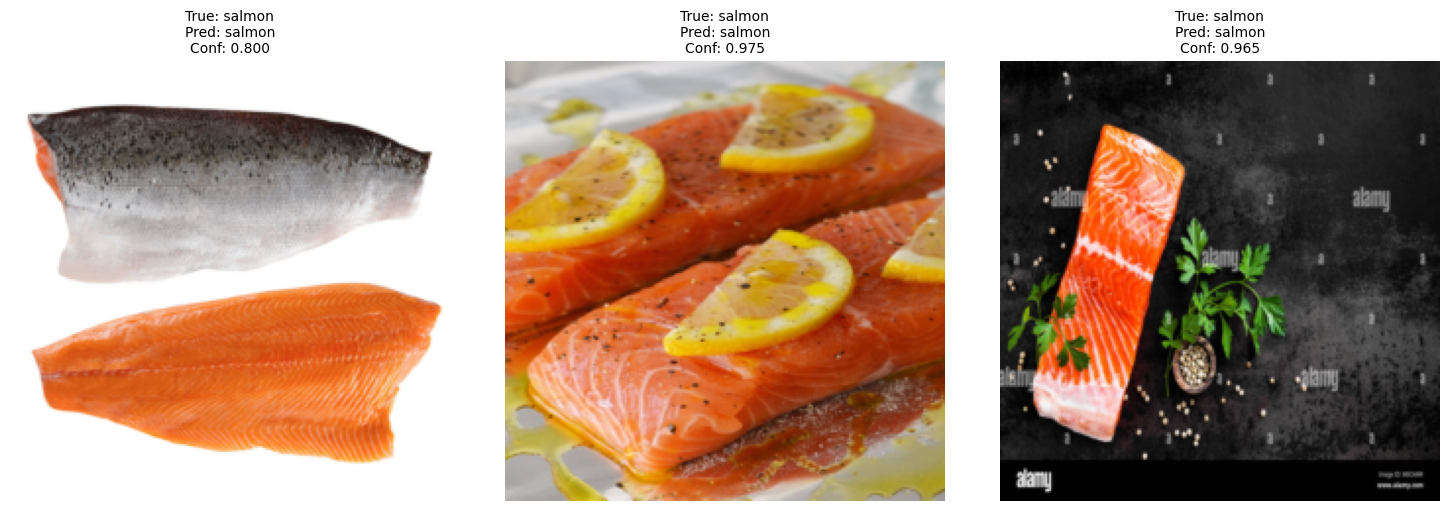

/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Detailed Predictions:

Sample 0:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0688
           cod: 0.0267
        salmon: 0.8000 ← PREDICTED
      sea bass: 0.0937
          tuna: 0.0108

Sample 1:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0088
           cod: 0.0008
        salmon: 0.9754 ← PREDICTED
      sea bass: 0.0115
          tuna: 0.0034

Sample 2:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0019
           cod: 0.0005
        salmon: 0.9647 ← PREDICTED
      sea bass: 0.0071
          tuna: 0.0258

Batch predicted classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 2, 2, 2], device='cuda:0')
Batch true classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


BATCH 12 RESULTS


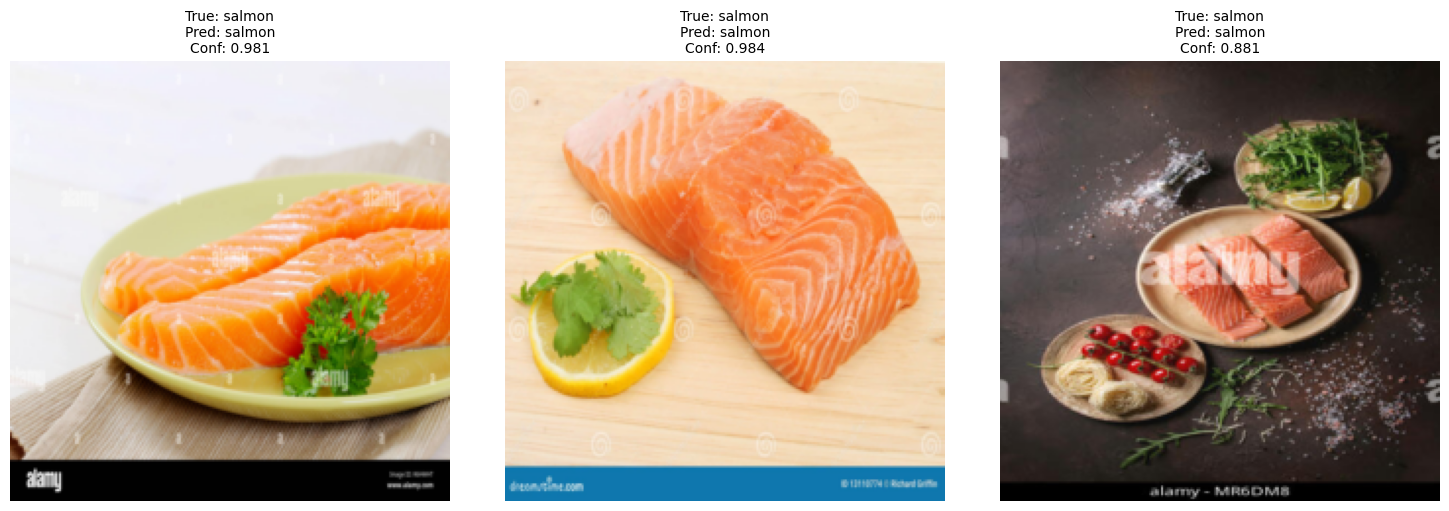


Detailed Predictions:

Sample 0:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0038
           cod: 0.0004
        salmon: 0.9809 ← PREDICTED
      sea bass: 0.0043
          tuna: 0.0105

Sample 1:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0052
           cod: 0.0016
        salmon: 0.9840 ← PREDICTED
      sea bass: 0.0046
          tuna: 0.0046

Sample 2:
  True class: salmon
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.0427
           cod: 0.0017
        salmon: 0.8807 ← PREDICTED
      sea bass: 0.0204
          tuna: 0.0545

Batch predicted classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 1, 1, 1], device='cuda:0')
Batch true classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3], device='cuda:0')


BATCH 14 RESULTS


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


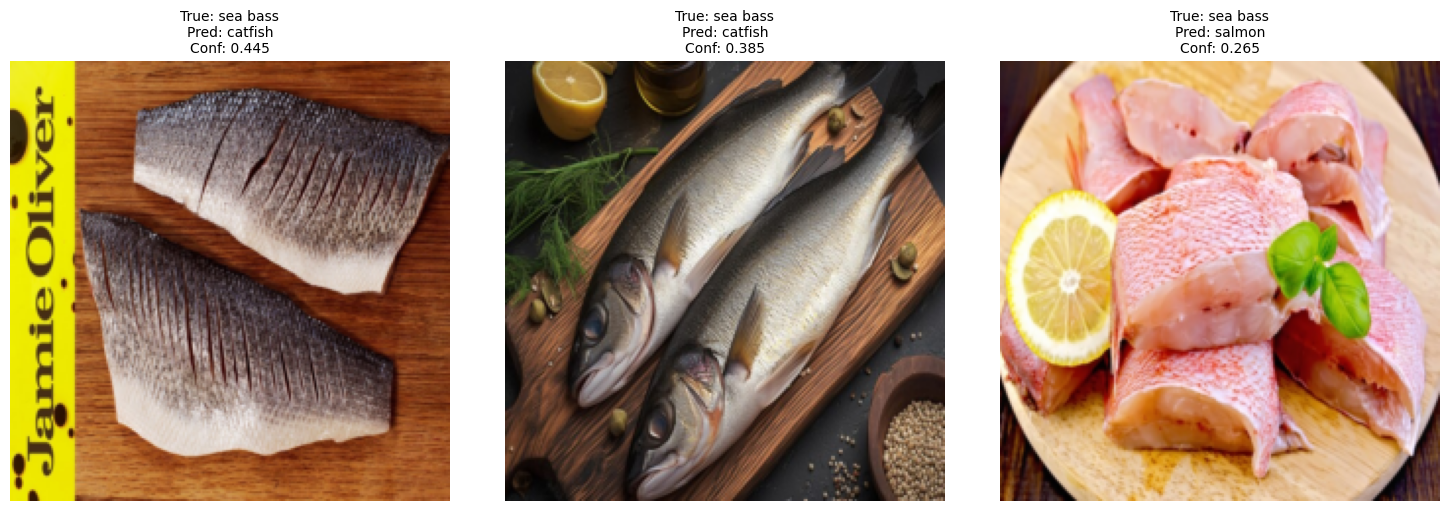


Detailed Predictions:

Sample 0:
  True class: sea bass
  Predicted class: catfish
  Likelihood vector:
       catfish: 0.4446 ← PREDICTED
           cod: 0.1936
        salmon: 0.0339
      sea bass: 0.2722
          tuna: 0.0559

Sample 1:
  True class: sea bass
  Predicted class: catfish
  Likelihood vector:
       catfish: 0.3850 ← PREDICTED
           cod: 0.0667
        salmon: 0.2104
      sea bass: 0.3229
          tuna: 0.0150

Sample 2:
  True class: sea bass
  Predicted class: salmon
  Likelihood vector:
       catfish: 0.2626
           cod: 0.2329
        salmon: 0.2646 ← PREDICTED
      sea bass: 0.0791
          tuna: 0.1608

Batch predicted classes: tensor([0, 0, 2, 3, 3, 3, 1, 3, 0, 0, 3, 3, 0, 3, 3, 3, 0, 1, 1, 3, 0, 3, 0, 2,
        3, 0, 1, 0, 3, 0, 3, 0], device='cuda:0')
Batch true classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

Test Loss: 1.3762, Accuracy: 0.28%


In [22]:
loss_fn = nn.CrossEntropyLoss()
test_loop(val_loader, model=model, loss_fn=loss_fn, device=device)